In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [ ]:
# Open quatratically detrended ts data for the 20 CMIP6 models 
data = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_ts_quad_detrend_1900_2015.nc')

In [3]:
# Select out tropical Pacific region and apply land mask as only inyterested in SST pattern for now 
sst_region = data.sel(lat=slice(-15,15)).sel(lon=slice(140,280))
#Landmask
landmask_ds = xr.open_dataset('/g/data/eg3/pfd548/gridarea/land-sea_mask/fractional_land.1.5-deg.nc')
landmask = landmask_ds.mean(dim='time')
# Apply to tropical Pacific region 
sst_region = sst_region.where(landmask.data==0)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 0:0:0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 0:0:0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into ful

In [4]:
# Calculate anomalies 
clims = sst_region.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anoms = sst_region.groupby('time.month') - clims

In [5]:
# Take DJF average
quarterly_anoms = anoms.resample(time='QS-DEC').mean('time')
djf_anoms = quarterly_anoms.isel(time=slice(0,None,4))

In [6]:
# Read in PCs
pcs = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_pcs.nc')

In [7]:
# Scale PCs to have a standard deviation of 1 
# Flip EOF2 for model MPI-ESM1-2-HR as pattern correlation with HadISST is negative 

pc1 = pcs.sel(mode=1)
pc2 = pcs.sel(mode=2)

norm_1 = []
for m in pc1.model:
    norm_1.append(pc1.sel(model=m)/pc1.sel(model=m).std())
    
pc1 = xr.DataArray(norm_1, coords=pc1.coords, attrs=pc1.attrs)

norm_2 = []
for m in pc2.model:
    if m == 'MPI-ESM1-2-HR':
        norm_2.append(pc2.sel(model=m)*-1/pc2.sel(model=m).std())
    else: norm_2.append(pc2.sel(model=m)/pc2.sel(model=m).std())
    
pc2 = xr.DataArray(norm_2, coords=pc2.coords, attrs=pc2.attrs)

In [8]:
# Calculate E-index and C-index
E = (pc1 - pc2)/np.sqrt(2)
C = (pc1 + pc2)/np.sqrt(2)

In [9]:
# Take DJF average of E-index and C-index
quarterly_E = E.resample(time='QS-DEC').mean('time')
djf_E = quarterly_E.isel(time=slice(0,None,4))

quarterly_C = C.resample(time='QS-DEC').mean('time')
djf_C = quarterly_C.isel(time=slice(0,None,4))

In [10]:
# Linear regression of SST anomalies onto E-index and C-index
E_regress_list = []
C_regress_list = []
for m in djf_anoms.model:
    E_regress_list.append(func.regress_nino(djf_anoms.sel(model=m), djf_E.sel(model=m)))
    C_regress_list.append(func.regress_nino(djf_anoms.sel(model=m), djf_C.sel(model=m)))

In [11]:
E_regressions = xr.concat(E_regress_list, dim='model')
C_regressions = xr.concat(C_regress_list, dim='model')

In [ ]:
fig = plt.figure(figsize=(20,7.5))
axs = []

columns = 4
rows = 5

for i, m in enumerate(E_regressions.model):
    # Flip pattern so positive regression in tropical pacific
    if E_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        d = E_regressions.sel(model=m)*-1
    else: d = E_regressions.sel(model=m)
    # Plot 
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    C = d.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

plt.savefig('CMIP6_EP_SST_pattern_EOF', bbox_inches='tight', dpi=300)

In [ ]:
fig = plt.figure(figsize=(20,7.5))
axs = []

columns = 4
rows = 5

for i, m in enumerate(C_regressions.model):
    # Flip pattern so positive regression in tropical pacific
    if C_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        d = C_regressions.sel(model=m)*-1
    else: d = C_regressions.sel(model=m)
    # Plot 
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    C = d.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

plt.savefig('CMIP6_CP_SST_pattern_EOF', bbox_inches='tight', dpi=300)

In [3]:
# Open HadISST 
sst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
sst = sst_ds.sst.sel(lat=slice(-15,15)).sel(lon=slice(140,280)).sel(time=slice('1900-01', '2014-12'))
# Quadtratically Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate anomalies 
clim = sst_dt.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = sst_dt.groupby('time.month') - clim
# EOFs
had_eof, had_pcs, had_var = func.eof_and_pcs(anom, 3)

In [4]:
# Take DJF averages of anoms 
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))

In [5]:
# Scale PCs to have a standrd deviation of 1 
had_pc1 = (had_pcs.sel(mode=1)/had_pcs.sel(mode=1).std())*-1
had_pc2 = had_pcs.sel(mode=2)/had_pcs.sel(mode=2).std()

In [6]:
# Calculate E-index and C-index
had_E = (had_pc1 - had_pc2)/np.sqrt(2)
had_C = (had_pc1 + had_pc2)/np.sqrt(2)

In [7]:
# Take DJF average of E-index and C-index
had_quarterly_E = had_E.resample(time='QS-DEC').mean('time')
had_djf_E = had_quarterly_E.isel(time=slice(0,None,4))

had_quarterly_C = had_C.resample(time='QS-DEC').mean('time')
had_djf_C = had_quarterly_C.isel(time=slice(0,None,4))

In [8]:
#Normalise 
had_djf_E = had_djf_E/had_djf_E.std()
had_djf_C = had_djf_C/had_djf_C.std()

In [9]:
E_regress_had = func.regress_nino(djf_anom, had_djf_E)
C_regress_had = func.regress_nino(djf_anom, had_djf_C)

In [10]:
%store -r EP_regress_had
%store -r CP_regress_had

In [45]:
def format_gridlines(ax, top_labels=False, bottom_labels=False, left_labels=False, right_labels=False):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.75, linestyle='--')
    gl.top_labels = top_labels
    gl.bottom_labels = bottom_labels
    gl.right_labels = right_labels
    gl.left_labels = left_labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    return ax

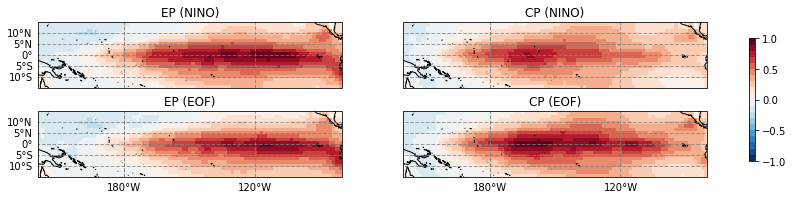

In [48]:
fig = plt.figure(figsize = (15,3)) 
axs = []

ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = EP_regress_had.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('RdBu_r', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP (NINO)')
ax = format_gridlines(ax, left_labels=True)
axs.append(ax)


ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = CP_regress_had.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('RdBu_r', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP (NINO)')
ax = format_gridlines(ax)
axs.append(ax)


ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = E_regress_had.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('RdBu_r', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP (EOF)')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)
axs.append(ax)

ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = C_regress_had.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('RdBu_r', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP (EOF)')
ax = format_gridlines(ax, bottom_labels=True)
axs.append(ax)

# Colorbar 
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
# Save fig
plt.savefig('HadISST_EP_CP_SST_pattern_NINO_EOF', bbox_inches='tight', dpi=300)

In [8]:
%store E_regress_had
%store C_regress_had

Stored 'E_regress_had' (DataArray)
Stored 'C_regress_had' (DataArray)


In [ ]:
fig = plt.figure(figsize = (15,2.5)) 
axs = []
ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
im = E_regress_had.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('E')
axs.append(ax)
ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
im = C_regress_had.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('C')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)

#plt.savefig('HadISST_EP_CP_SST_pattern_EOF', bbox_inches='tight', dpi=300)

In [22]:
E_regressions_new = []
for m in E_regressions.model:
    if E_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        E_regressions_new.append(E_regressions.sel(model=m)*-1)
    else: E_regressions_new.append(E_regressions.sel(model=m))
E_regressions_new = xr.concat(E_regressions_new, dim='model')

In [23]:
C_regressions_new = []
for m in C_regressions.model:
    if C_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        C_regressions_new.append(C_regressions.sel(model=m)*-1)
    else: C_regressions_new.append(C_regressions.sel(model=m))
C_regressions_new = xr.concat(C_regressions_new, dim='model')

In [26]:
# Pattern Correlations
E_pattern_cor = []
for m in E_regressions.model:
    E_pattern_cor.append(func.pattern_cor(E_regressions_new.sel(model=m), E_regress_had))
    
C_pattern_cor = []
for m in C_regressions.model:
    C_pattern_cor.append(func.pattern_cor(C_regressions_new.sel(model=m), C_regress_had))

In [27]:
had_EP_sst_eof = E_pattern_cor.copy()
had_CP_sst_eof = C_pattern_cor.copy()

In [28]:
%store had_EP_sst_eof
%store had_CP_sst_eof

Stored 'had_EP_sst_eof' (list)
Stored 'had_CP_sst_eof' (list)


In [ ]:
# Make pandas dataframe 
model_names = data.model.values
names = list(model_names)

pandas_data = []
for i in np.arange(0,len(names)):
    cell = [names[i], np.absolute(E_pattern_cor[i]), np.absolute(C_pattern_cor[i])]
    pandas_data.append(cell)
    
df = pd.DataFrame(pandas_data, columns=['Model', 'E', 'C'])
df.head()

In [ ]:
df.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(loc=(1.01,0.7))
plt.title('Pattern Correlation for EP and CP between models and HadISST (EOF based method)')
plt.savefig('CMIP6_EP_CP_pattern_corr_EOF', bbox_inches='tight', dpi=300)

In [ ]:
# Rename df to pass to other notebook
df_EOF = df.copy()

In [ ]:
%store df_EOF

#### Location of Maximum Variability 

In [18]:
E_longitudes = []

for m in E_regressions.model:
    if E_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        a = E_regressions.sel(model=m)*-1
    else: a = E_regressions.sel(model=m)
        
    location = np.where(a == np.max(a))
    lon_index = location[1][0]
    longitude = a.isel(lon=lon_index).lon.values
    
    E_longitudes.append(longitude)

In [19]:
C_longitudes = []

for m in C_regressions.model:
    if C_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        a = C_regressions.sel(model=m)*-1
    else: a = C_regressions.sel(model=m)
        
    location = np.where(a == np.max(a))
    lon_index = location[1][0]
    longitude = a.isel(lon=lon_index).lon.values
    
    C_longitudes.append(longitude)

In [21]:
had_location_E = np.where(E_regress_had == np.max(E_regress_had))
had_lon_index_E = had_location_E[1][0]
had_longitude_E = E_regress_had.isel(lon=had_lon_index_E).lon.values

In [22]:
had_location_C = np.where(C_regress_had == np.max(C_regress_had))
had_lon_index_C = had_location_C[1][0]
had_longitude_C = C_regress_had.isel(lon=had_lon_index_C).lon.values

In [51]:
def draw_plot(data, edge_color, fill_color, positions):
    bp = ax.boxplot(data, patch_artist=True, positions=positions, widths=0.6, vert=False)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color, alpha=0.5) 

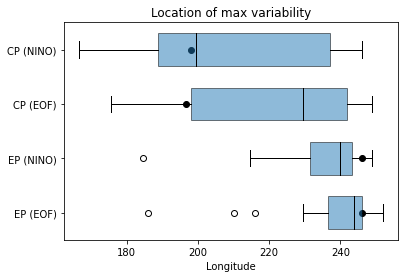

In [53]:
fig, ax = plt.subplots()
draw_plot([E_longitudes, EP_longitudes, C_longitudes, CP_longitudes], 'black', None, [1,2,3,4])
ax.set_yticklabels(['EP (EOF)', 'EP (NINO)', 'CP (EOF)', 'CP (NINO)'])
ax.set_xlabel('Longitude')
ax.set_title('Location of max variability')
# Add dots for hadisst
plt.scatter(had_longitude_CP,4, c='black')
plt.scatter(had_longitude_C,3, c='black')
plt.scatter(had_longitude_EP,2, c='black')
plt.scatter(had_longitude_E,1, c='black')
#plt.savefig('Location of max variability', bbox_inches='tight', dpi=300)

In [24]:
%store -r EP_longitudes

In [25]:
%store -r CP_longitudes

In [26]:
%store -r had_longitude_EP

In [27]:
%store -r had_longitude_CP

In [34]:
had_longitude_CP

array(198.)